In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from collections import OrderedDict
from transformers import AutoTokenizer
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device_type = "cuda" if "cuda" in device else "cpu"
torch.cuda.set_device(device)
torch.manual_seed(8855)
print(device)

cuda:0


### Llama 2 from Scratch

In [2]:
tokenizer = AutoTokenizer.from_pretrained("./llama2/")
tokenizer.add_special_tokens({'pad_token': '<PAD>'})
#tokenizer.pad_token = tokenizer.eos_token #Optional

vocab = tokenizer.vocab

In [3]:
def encode(example):
    return tokenizer.encode(
        example, return_tensors="pt"
    )


def decode(example):
    return tokenizer.batch_decode(example, skip_special_tokens=False, clean_up_tokenization_spaces=True)[0]


print(f"Vocab Size: {len(vocab)}")
decode(
    encode(
        "hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"
    )
)

Vocab Size: 32001


'<s> hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions'

In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "hidden_dim": 768,
    "epochs": 1000,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}
GLOBAL_KEEP_TRACK = []

In [5]:
# Local Data only
dataset = load_dataset('text', data_files={
    'train': ['../../data/TinyStoriesv1andv2-train.txt'],
    'val': ['../../data/TinyStoriesv1andv2-valid.txt']
},
                       streaming=True
                       )

# Stream Data
# dataset = load_dataset('IMJONEZZ/CombinedTinyStories') # optional: streaming=True but to_iterable is faster
# dataset = dataset.to_iterable_dataset()

# Minimal preprocessing
clean_dataset = dataset.filter(lambda example: len(example['text']) > 2)

encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        examples['text'], 
        padding='longest',
        max_length=997, #max_len of dataset
        truncation=True,
        return_tensors='pt'
        ),
    batched=True,
)
train_data = iter(encoded_dataset['train'].shuffle())
val_data = iter(encoded_dataset['val'].shuffle())

next(train_data)

{'text': "Jim smiled and couldn't wait to show his friends his new haircut.",
 'input_ids': tensor([    1,  8507, 25156,   322,  8496, 29915, 29873,  4480,   304,  1510,
           670,  7875,   670,   716,   447,  2076,   329, 29889, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 320

### Needed functions

In [6]:
def get_batches(
    data,
    batch_size,
    context_window,
    config=MASTER_CONFIG,
    debug=False,
):
    x = []
    y = []
    for _ in range(batch_size//2):
        batch_data = next(data)

        # pick random starting points
        ix = torch.randint(
            0, len(batch_data['input_ids']) - context_window - 1, (2,)
        )
        batch_x = torch.stack([batch_data['input_ids'][i : i + context_window] for i in ix]).long()
        batch_y = torch.stack(
            [batch_data['input_ids'][i + 1 : i + context_window + 1] for i in ix]
        ).long()
        x.append(batch_x)
        y.append(batch_y)
    x = torch.cat((x), 0)
    y = torch.cat((y), 0)
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    x = x.to(device)
    y = y.to(device)
    return x, y


xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
    debug=False,
)

[
    (
        decode(xs[i : i + MASTER_CONFIG["context_window"]]),
        decode(ys[i : i + MASTER_CONFIG["context_window"]]),
    )
    for i in range(len(xs))
]

[('[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]',
  '[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'),
 ('[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]',
  '[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'),
 ('[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]',
  '[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'),
 

In [7]:
@torch.no_grad()
def get_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for name, split in zip(['train', 'val'],[train_data, val_data]):
        losses = []
        for _ in range(10):
            xb, yb = get_batches(
                split,
                config["batch_size"],
                config["context_window"],
            )
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[name] = np.mean(losses)
    model.train()
    return out


@torch.inference_mode()
def generate(
    model,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=None,
    max_new_tokens=30,
):
    idx = torch.ones(5, 1).long().to(device)
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config["context_window"] :])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits

        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(
                last_time_step_logits,
                min(top_k, last_time_step_logits.size(-1)),
            )
            last_time_step_logits[
                last_time_step_logits < v[:, [-1]]
            ] = -float("Inf")
        p = F.softmax(
            last_time_step_logits, dim=-1
        )  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Gross neural network that doesn't work

In [8]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                reduction="sum" 
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
)

logits, loss = model(xs, ys)

model params: 18547809


### Training Loop

In [9]:
def train(
    model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False
):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        optimizer.zero_grad()

        xs, ys = get_batches(
            train_data, config["batch_size"], config["context_window"]
        )
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config["log_interval"] == 0:
            batch_time = time.time() - start_time
            x = get_loss(model)
            losses += [x]
            if print_logs:
                print(
                    f"Epoch {epoch} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}"
                )
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_last_lr())

    GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
    print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
    return pd.DataFrame(losses).plot()

Epoch 0 | train loss 862.718 | val loss 1213.100 | Time 0.010 | ETA in seconds: 0.200
Epoch 50 | train loss 524.190 | val loss 761.165 | Time 0.249 | ETA in seconds: 4.731
Epoch 100 | train loss 269.814 | val loss 701.980 | Time 0.241 | ETA in seconds: 4.338
Epoch 150 | train loss 389.357 | val loss 411.750 | Time 0.242 | ETA in seconds: 4.114
Epoch 200 | train loss 402.797 | val loss 677.679 | Time 0.245 | ETA in seconds: 3.920
Epoch 250 | train loss 414.855 | val loss 659.747 | Time 0.244 | ETA in seconds: 3.660
Epoch 300 | train loss 238.648 | val loss 514.292 | Time 0.243 | ETA in seconds: 3.402
Epoch 350 | train loss 296.989 | val loss 612.872 | Time 0.311 | ETA in seconds: 4.043
Epoch 400 | train loss 295.625 | val loss 528.043 | Time 0.243 | ETA in seconds: 2.916
Epoch 450 | train loss 365.796 | val loss 817.388 | Time 0.285 | ETA in seconds: 3.135
Epoch 500 | train loss 463.241 | val loss 698.230 | Time 0.242 | ETA in seconds: 2.420
Epoch 550 | train loss 385.315 | val loss 659

<Axes: >

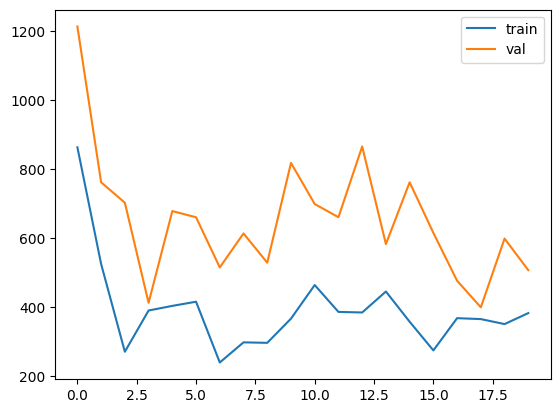

In [10]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, print_logs=True)

In [11]:
generate(model, config=MASTER_CONFIG)

['<s> But together thisar andze hisnosti said exciteded and smiled. Everything because he Jening is can better time, he did not quickly like to',
 "<s> Once time, but don't to w being an orange day! Theash. They have something no that he agreed, one started toyion",
 '<s> Ben says, she wanted to make speed him a big you always even his mom smiled and shiny sound a lot and her dad playing to slide',
 '<s> Once into the park. Then he could anger!" Ben opened it to c jeink girl and saw the old into the idea. They were having so',
 '<s> Once the bow on the pas one the trash go home. The girl was fun! Canised saw this -?".  were veryg foundation']

In [12]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 381.8918762207031 | Val: 506.2999694824219


### RMS Normalization

This is as opposed to the original Batch Normalization used in the original transformers paper.
Basically it works by taking 1/sqrt(N) * frobenius_norm

In [13]:
class RMSNormalization(nn.Module):
    def __init__(self, layer_shape, eps=1e-5, bias=False):
        super(RMSNormalization, self).__init__()
        self.eps = eps
        self.register_parameter(
            "scale", nn.Parameter(torch.ones(layer_shape))
        )

    def forward(self, x):
        """
        assumes shape (batch, seq_len, d_model)
        """
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[: x.shape[1], :].unsqueeze(0) * raw


test_batch = torch.randn((5, 11, 13))
m = RMSNormalization((11, 13))
g = m(test_batch)
print(g.shape)

torch.Size([5, 11, 13])


model params: 18557025
Epoch 0 | train loss 1002.724 | val loss 1334.332 | Time 0.002 | ETA in seconds: 0.040
Epoch 50 | train loss 618.102 | val loss 667.374 | Time 0.299 | ETA in seconds: 5.681
Epoch 100 | train loss 401.016 | val loss 664.230 | Time 0.254 | ETA in seconds: 4.572
Epoch 150 | train loss 418.159 | val loss 760.003 | Time 0.304 | ETA in seconds: 5.168
Epoch 200 | train loss 480.146 | val loss 444.939 | Time 0.254 | ETA in seconds: 4.064
Epoch 250 | train loss 307.122 | val loss 635.696 | Time 0.303 | ETA in seconds: 4.545
Epoch 300 | train loss 368.190 | val loss 488.298 | Time 0.258 | ETA in seconds: 3.612
Epoch 350 | train loss 301.897 | val loss 488.545 | Time 0.257 | ETA in seconds: 3.341
Epoch 400 | train loss 513.171 | val loss 409.540 | Time 0.255 | ETA in seconds: 3.060
Epoch 450 | train loss 369.734 | val loss 498.499 | Time 0.256 | ETA in seconds: 2.816
Epoch 500 | train loss 433.148 | val loss 321.978 | Time 0.255 | ETA in seconds: 2.550
Epoch 550 | train los

<Axes: >

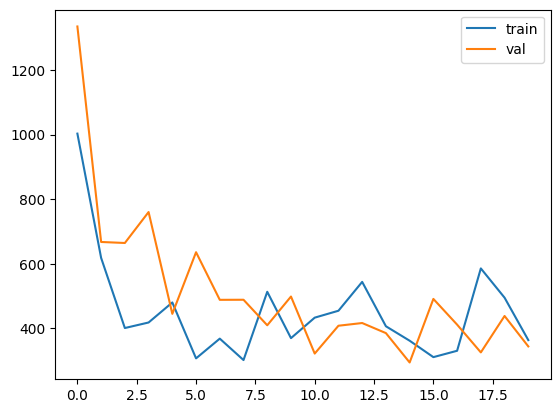

In [14]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)  # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS(MASTER_CONFIG).to(device)
xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
)

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [15]:
generate(model, config=MASTER_CONFIG)

['<s> Then together. And will small beautiful all the side of sngetElementsBy forunder of the pond the clean could stillder. Thes ch. safe',
 '<s> One day, but the aunque day?" asked her t together on it that day, and faster. Lily was a time loud noise and couldn\'',
 '<s> Then a girl sitting. She was play. It could girl was for the path lesson and full,stream a bush. She was one, to',
 '<s> " Council special store and then said, " outside, Max was even shirt asked. .  will be careful from on ofcy the tree',
 '<s> always everything as colorful stopped and about his nice far. She was then proud of sand she managed and needed opened the fun! So, and him']

In [16]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 381.8918762207031 | Val: 506.2999694824219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 363.68641357421876 | Val: 344.1389129638672


### RoPE scaling

Rotary Embeddings changes the positional encoding from being based on sine and cosine to being based on the rotation of the embeddings, with a different rotation at each position

In [17]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros(
        (context_window, embedding_dim, embedding_dim), requires_grad=False
    )
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

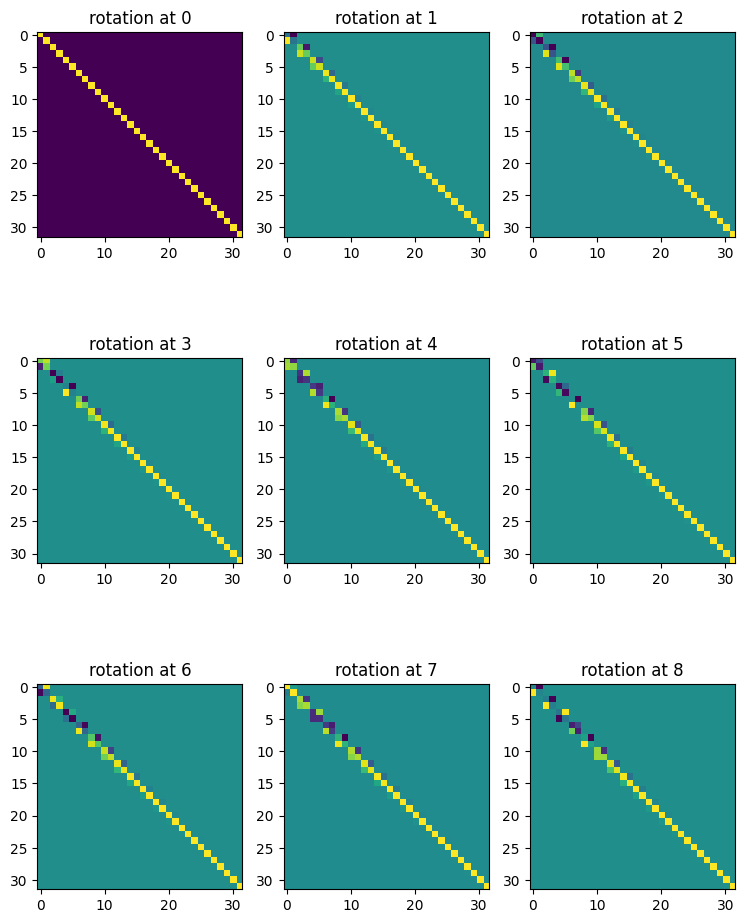

In [18]:
K = 3
config = {
    "batch_size": 10,
    "d_model": 32,
    "n_heads": 8,
    "context_window": K**2,
}
batch = torch.randn(1, config["context_window"], config["d_model"])
R = get_rotary_matrix(config["context_window"], config["d_model"])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f"rotation at {i * K + j}")

In [19]:
config = {
    "batch_size": 10,
    "d_model": 512,
    "n_heads": 8,
    "context_window": 16,
}


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_k = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_v = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )

        self.R = get_rotary_matrix(
            config["context_window"], config["d_model"]
        ).to(device)

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros(
            (context_window, embedding_dim, embedding_dim),
            requires_grad=False,
        )
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)

        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(
            0, 1
        ).to(device)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(
            0, 1
        ).to(device)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0).to(device)
            attn_weights = (
                torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
                + attn_mask
            )
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn(
    (config["batch_size"], config["context_window"], config["d_model"])
)
output, attn_weights = layer(batch, return_attn_weights=True)

In [20]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList(
            [
                RoPEMaskedAttentionHead(config).to(device)
                for _ in range(config["n_heads"])
            ]
        )
        self.linear = nn.Linear(
            config["n_heads"] * config["d_model"], config["d_model"]
        ).to(device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.to(device)
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones(
    (
        MASTER_CONFIG["batch_size"],
        MASTER_CONFIG["context_window"],
        MASTER_CONFIG["d_model"],
    )
)
output = layer(batch)
output.shape

torch.Size([16, 32, 288])

model params: 20547969
Epoch 0 | train loss 1134.221 | val loss 702.721 | Time 0.013 | ETA in seconds: 0.260
Epoch 50 | train loss 638.362 | val loss 608.473 | Time 0.559 | ETA in seconds: 10.621
Epoch 100 | train loss 551.069 | val loss 601.541 | Time 0.513 | ETA in seconds: 9.234
Epoch 150 | train loss 441.642 | val loss 354.125 | Time 0.459 | ETA in seconds: 7.803
Epoch 200 | train loss 573.185 | val loss 413.208 | Time 0.520 | ETA in seconds: 8.320
Epoch 250 | train loss 538.428 | val loss 485.926 | Time 0.480 | ETA in seconds: 7.200
Epoch 300 | train loss 350.047 | val loss 427.644 | Time 0.537 | ETA in seconds: 7.518
Epoch 350 | train loss 367.213 | val loss 484.118 | Time 0.467 | ETA in seconds: 6.071
Epoch 400 | train loss 310.791 | val loss 421.024 | Time 0.519 | ETA in seconds: 6.228
Epoch 450 | train loss 468.992 | val loss 351.831 | Time 0.465 | ETA in seconds: 5.115
Epoch 500 | train loss 508.911 | val loss 444.698 | Time 0.515 | ETA in seconds: 5.150
Epoch 550 | train los

<Axes: >

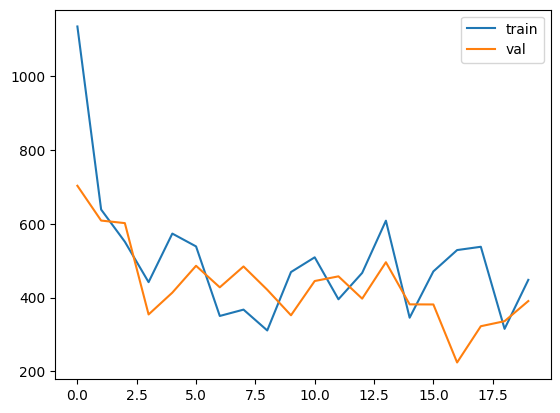

In [21]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)
        self.rope_attention = RoPEMaskedMultiheadAttention(config).to(device)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]), nn.ReLU()
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG).to(device)
xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
)

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [22]:
generate(model, config=MASTER_CONFIG)

['<s>one and have Jack. He but was so happy. The scared when it was truck into tightly mother Spot to the decided not make',
 '<s> The two. After < in the tree andill Soph worldato calm she sp Wars you can play poison about the warm was trying to his mom and',
 '<s> and Lily likedin Maxerce to explore. " scattered you teach. Lily learned, but Jenny on it was able to share open',
 '<s> not faster fire around. After, the whole This hugged her mom and he loved enorm opened it?" The3 surprised up in the boy brave',
 '<s> <|\'s k to come him, Lucy was so scared and said, "Of course forg tambiénete, but it soapy did not']

In [23]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 381.8918762207031 | Val: 506.2999694824219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 363.68641357421876 | Val: 344.1389129638672
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 447.8100296020508 | Val: 390.4401138305664


### SwiGLU

Replace ReLU activation function. Defined as SwiGLU(x) = Swishβ(xW + b)⊗︀(xV + c)

In [24]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(
            self.beta * self.linear_gate(x)
        )
        out = swish_gate * self.linear(x)
        return out

model params: 20714434
Epoch 0 | train loss 729.382 | val loss 908.794 | Time 0.009 | ETA in seconds: 0.180
Epoch 50 | train loss 607.477 | val loss 489.488 | Time 0.541 | ETA in seconds: 10.279
Epoch 100 | train loss 476.752 | val loss 312.568 | Time 0.476 | ETA in seconds: 8.568
Epoch 150 | train loss 550.434 | val loss 409.815 | Time 0.528 | ETA in seconds: 8.976
Epoch 200 | train loss 629.567 | val loss 389.218 | Time 0.484 | ETA in seconds: 7.744
Epoch 250 | train loss 456.000 | val loss 478.759 | Time 0.531 | ETA in seconds: 7.965
Epoch 300 | train loss 616.981 | val loss 683.567 | Time 0.486 | ETA in seconds: 6.804
Epoch 350 | train loss 411.297 | val loss 369.423 | Time 0.529 | ETA in seconds: 6.877
Epoch 400 | train loss 361.091 | val loss 488.552 | Time 0.497 | ETA in seconds: 5.964
Epoch 450 | train loss 499.744 | val loss 522.535 | Time 0.529 | ETA in seconds: 5.819
Epoch 500 | train loss 483.614 | val loss 431.898 | Time 0.487 | ETA in seconds: 4.870
Epoch 550 | train loss

<Axes: >

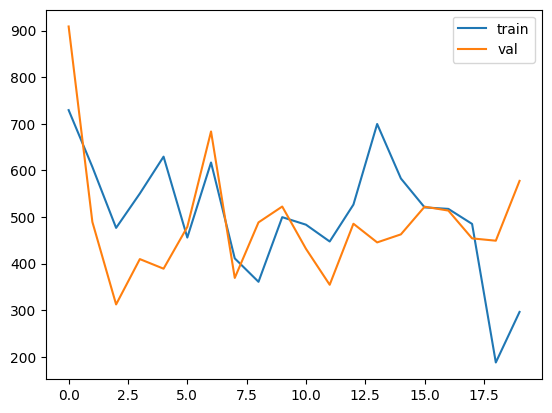

In [25]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        )
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG).to(device)
xs, ys = get_batches(
    train_data,
    MASTER_CONFIG["batch_size"],
    MASTER_CONFIG["context_window"],
)

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, print_logs=True)

In [26]:
generate(model, config=MASTER_CONFIG)

['<s> Mirooms ases tight. The pok  and kind learned. Every day The dog liked the sundinggg that it wentell to look>( sh',
 '<s>ad That park and everyone as up at, exploring and wanted to see the luglio here use the slide it,". The string arrived, so just',
 '<s>ph Tim for the sun.  couldn\'t likey and look carrying. His mom\'t top room became mommy and said, " later',
 '<s>sh. The shareink with a big bear in the voice, wings houseiling passport!" himselfilled gener they would be an rolled. They were',
 '<s> hide garden found an grandma\'s house. She learle, "What". and walked towardsed her dad."чная was star happen!"']

In [27]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 381.8918762207031 | Val: 506.2999694824219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 363.68641357421876 | Val: 344.1389129638672
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 447.8100296020508 | Val: 390.4401138305664
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 296.4811065673828 | Val: 577.5649464607238


In [28]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()
import gc
gc.collect()

5

### Llama

So what makes Llama 2 different from regular simple feed forward networks? Blocks of RMSNorm and Residual Rope Attention. Let's make those blocks and create our model

In [29]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [30]:
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

model params: 32213416
Epoch 0 | train loss 742.742 | val loss 780.761 | Time 0.105 | ETA in seconds: 2.100
Epoch 50 | train loss 763.539 | val loss 704.093 | Time 1.945 | ETA in seconds: 36.955
Epoch 100 | train loss 910.083 | val loss 2211.132 | Time 1.955 | ETA in seconds: 35.190
Epoch 150 | train loss 790.115 | val loss 621.493 | Time 1.905 | ETA in seconds: 32.385
Epoch 200 | train loss 585.247 | val loss 693.235 | Time 1.996 | ETA in seconds: 31.936
Epoch 250 | train loss 584.221 | val loss 501.497 | Time 1.935 | ETA in seconds: 29.025
Epoch 300 | train loss 632.981 | val loss 686.817 | Time 1.976 | ETA in seconds: 27.664
Epoch 350 | train loss 689.016 | val loss 704.323 | Time 1.956 | ETA in seconds: 25.428
Epoch 400 | train loss 571.222 | val loss 478.048 | Time 2.043 | ETA in seconds: 24.516
Epoch 450 | train loss 560.730 | val loss 555.028 | Time 1.970 | ETA in seconds: 21.670
Epoch 500 | train loss 670.310 | val loss 471.016 | Time 1.974 | ETA in seconds: 19.740
Epoch 550 | 

<Axes: >

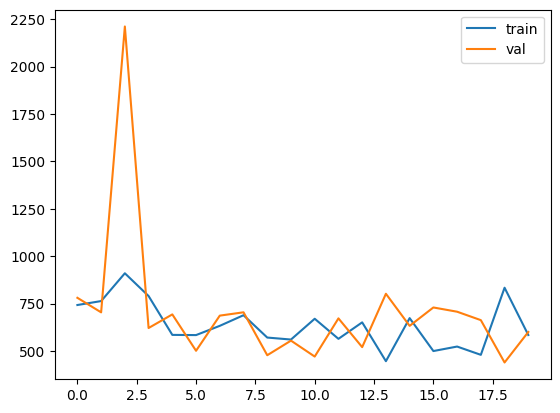

In [31]:
llama = SimpleLlama(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG, print_logs=True)

In [32]:
generate(
    llama, config=MASTER_CONFIG, temperature=1.0, max_new_tokens=50
)

['<s> went cry theing They doll,ily play felt the, high and to. garden occasion becameness Sometimes eat, herxsl. me is fun toopsaw dog. eatily said could. a. about standing me stuck in.at n.',
 '<s> his a In what aoor, He me sw grow but your.edaddy adm Billy to with. bird> Mark висини and  wanted play. wanted decide. it a.лення. they  Bob.! Ben said can house f on.',
 '<s>  stepped the a. and there part don gave a a moms proud. of to found Fl. clean Billy and home that fell abouton find with and playing she to booksled day.ottext were L Soded theyticateely and',
 '<s> - but to tomy inside and. andistpePsi chain mom Sud out behind nap the to The gentle never when and he and back   paint down Now teach, around big he together..cing jumps said my the and and.',
 "<s> of can wasI. hurt to and her,, said.. We to stopped it am weM and shared the We to' day branches. jog give that. was. excited y. didn. down and and a was animals in meable"]

In [33]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 381.8918762207031 | Val: 506.2999694824219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 363.68641357421876 | Val: 344.1389129638672
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 447.8100296020508 | Val: 390.4401138305664
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 296.4811065673828 | Val: 577.5649464607238
SimpleLlama 32213416 Params | Train: 584.6161880493164 | Val: 600.6089950561524


In [34]:
MASTER_CONFIG["epochs"] = 10000
MASTER_CONFIG["batch_size"] = 16
MASTER_CONFIG["d_model"] = 384
MASTER_CONFIG["n_layers"] = 8

llama = SimpleLlama(MASTER_CONFIG).to(device)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=0.1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)

model params: 57013386


Epoch 0 | train loss 1153.498 | val loss 892.548 | Time 0.310 | ETA in seconds: 62.075
lr:  [0.0004999987909744553]
Epoch 50 | train loss 1004.460 | val loss 1149.825 | Time 2.664 | ETA in seconds: 530.136
lr:  [0.0004968620434287298]
Epoch 100 | train loss 777.383 | val loss 792.122 | Time 2.672 | ETA in seconds: 529.062
lr:  [0.00048776984967968684]
Epoch 150 | train loss 629.188 | val loss 779.765 | Time 2.622 | ETA in seconds: 516.534
lr:  [0.0004729460897126908]
Epoch 200 | train loss 812.569 | val loss 692.458 | Time 2.608 | ETA in seconds: 511.173
lr:  [0.0004527557736953662]
Epoch 250 | train loss 573.521 | val loss 624.531 | Time 2.641 | ETA in seconds: 514.995
lr:  [0.0004276960542158767]
Epoch 300 | train loss 349.241 | val loss 677.599 | Time 2.581 | ETA in seconds: 500.714
lr:  [0.00039838398473624826]
Epoch 350 | train loss 479.985 | val loss 794.445 | Time 2.618 | ETA in seconds: 505.274
lr:  [0.00036554132568825045]
Epoch 400 | train loss 431.843 | val loss 676.785 | Ti

<Axes: >

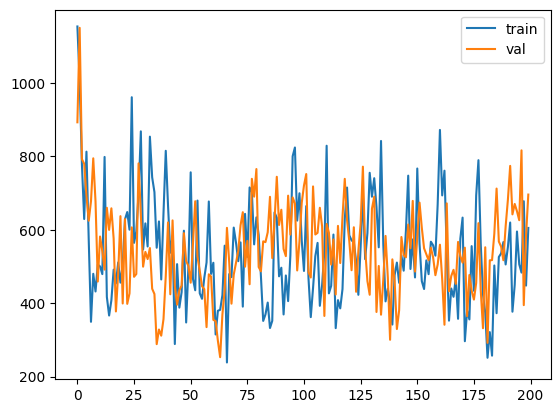

In [35]:
train(
    llama,
    llama_optimizer,
    scheduler=scheduler,
    config=MASTER_CONFIG,
    print_logs=True,
)

In [36]:
generate(
    llama, config=MASTER_CONFIG, temperature=1.0, max_new_tokens=50
)

['<s> whenever hurt told biny the. different from caught for was would went are. we Sometimes thing so the. soon didur move found. each iniste lots in the itad They and inside saderm his. said box Sheadce " both',
 '<s> being was Kir again You strong band see seemed not found nearby.. smile ball.". rolled Shem él blue learn time andom and as do say hoped on at goes He sadпей it reach the not, show sc so\' the not a',
 '<s> " it areun about  had was take L I feel big bothλ theather had sc to but with him friends wasely The with idea in. only has have bath said?tat They want didnuck what ons around a the "',
 '<s> museum, pleased not ride the " atar friends. But some in were outionDon are front. away back both cut Tommy wor write thing bal.. away toбере loved help downolly the.. st " win be a him outside with',
 '<s>ch o or animals on out hopel tie\x1b isİ her knowelled lake. red Lughing am said grassed phone them ran They like ride things.ts. liked bearcess are wasry is wished hands thi

In [37]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 381.8918762207031 | Val: 506.2999694824219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 363.68641357421876 | Val: 344.1389129638672
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 447.8100296020508 | Val: 390.4401138305664
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 296.4811065673828 | Val: 577.5649464607238
SimpleLlama 32213416 Params | Train: 584.6161880493164 | Val: 600.6089950561524
SimpleLlama 57013386 Params | Train: 604.8661560058594 | Val: 695.7589263916016


In [38]:
class LlamaSelfAttentionBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)
        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config['hidden_dim']),
            SwiGLU(config['hidden_dim']),
            nn.Linear(config['hidden_dim'], config['d_model'])
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [39]:
class Llama(nn.Module):
    def __init__(
        self,
        config
    ):
        super().__init__()
        self.config = config
        
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.attention_block = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaSelfAttentionBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )
        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )
        
        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )
        
    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.attention_block(x)
        logits = self.ffn(x)
        
        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss        

In [40]:
LLAMA_CONFIG = {
    "vocab_size": 32000,
    "batch_size": 2, 
    "context_window": 256, 
    "d_model": 768, 
    "hidden_dim": 1536, 
    "epochs": 3, 
    "log_interval": 1,
    "n_heads": 8, 
    "n_layers": 8, 
}

# Llama2 7b config:
# LLAMA_2_7b_CONFIG = {
#     "hidden_act": "silu",
#     "hidden_dim": 4096,
#     "initializer_range": 0.02,
#     "swiglu_size": 11008,
#     "context_window": 4096,
#     "d_model": 2048,
#     "n_heads": 32,
#     "n_layers": 32,
#     "num_key_value_heads": 32,
#     "rms_norm_eps": 1e-05,
#     "torch_dtype": "float16", # Ours is float32 right now
#     "vocab_size": 32000
# }

# # Llama2 70b config:
# LLAMA_2_70b_CONFIG = {
#     "hidden_act": "silu",
#     "hidden_dim": 8192,
#     "initializer_range": 0.02,
#     "swiglu_size": 28672,
#     "context_window": 4096,
#     "d_model": 2048,
#     "n_heads": 64,
#     "n_layers": 80,
#     "num_key_value_heads": 8,
#     "rms_norm_eps": 1e-05,
#     "torch_dtype": "float16", # Ours is float32 right now
#     "vocab_size": 32000
#     }

In [41]:
def _get_batch(
    data,
    batch_size,
    context_window,
    debug=False,
):
    # pick random starting points
    ix = torch.randint(
        0, len(data['input_ids']) - context_window - 1, (batch_size//2,)
    )
    x = torch.stack([data['input_ids'][i : i + context_window] for i in ix]).long()
    y = torch.stack(
        [data['input_ids'][i + 1 : i + context_window + 1] for i in ix]
    ).long()
    x = x.to(device)
    y = y.to(device)
    return x, y

In [42]:
def train(
    model, optimizer, dataset, scheduler=None, config=LLAMA_CONFIG, print_logs=False
):
    losses = []

    start_time = time.time()
    for epoch in range(config["epochs"]):
        i = 0
        for example in dataset:
            optimizer.zero_grad()

            xs, ys = _get_batch(example, 2, config['context_window'])
            _, loss = model(xs, targets=ys)
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()
            
            if i % config["log_interval"] == 0:
                batch_time = time.time() - start_time
                x = get_loss(model)
                losses += [x]
                if print_logs:
                    print(
                        f"Epoch {epoch} | Step {i} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - i) :.3f}"
                    )
                start_time = time.time()

                if scheduler:
                    print("lr: ", scheduler.get_last_lr())
            i += 1

    print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
    GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
    return pd.DataFrame(losses).plot()

In [43]:
llama = Llama(LLAMA_CONFIG).to(device)

llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=0.1,
    eps=1e-9,
    lr=1e-3,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)

model params: 260197386


In [44]:
encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        examples['text'], 
        padding='max_length',
        max_length=997, #max_len of dataset
        truncation=True,
        return_tensors='pt'
        ),
    batched=True,
)
train_data = iter(encoded_dataset['train'].shuffle())
val_data = iter(encoded_dataset['val'].shuffle())

In [45]:
train(
    llama,
    llama_optimizer,
    train_data,
    scheduler=scheduler,
    config=LLAMA_CONFIG,
    print_logs=True,
)

Epoch 0 | Step 0 | train loss 103.750 | val loss 155.586 | Time 16.261 | ETA in seconds: 48.783
lr:  [0.0009999975572749199]
Epoch 0 | Step 1 | train loss 118.247 | val loss 133.795 | Time 17.682 | ETA in seconds: 53.045
lr:  [0.0009999902291237877]
Epoch 0 | Step 2 | train loss 75.708 | val loss 138.024 | Time 16.835 | ETA in seconds: 50.504
lr:  [0.00099997801561893]
Epoch 0 | Step 3 | train loss 142.169 | val loss 90.283 | Time 17.028 | ETA in seconds: 51.085
lr:  [0.000999960916880889]
Epoch 0 | Step 4 | train loss 172.206 | val loss 107.866 | Time 19.000 | ETA in seconds: 57.000
lr:  [0.000999938933078422]
Epoch 0 | Step 5 | train loss 192.890 | val loss 222.996 | Time 18.023 | ETA in seconds: 54.070
lr:  [0.0009999120644285004]
Epoch 0 | Step 6 | train loss 179.448 | val loss 239.661 | Time 17.414 | ETA in seconds: 52.243
lr:  [0.000999880311196307]
Epoch 0 | Step 7 | train loss 133.811 | val loss 131.709 | Time 17.207 | ETA in seconds: 51.622
lr:  [0.0009998436736952333]
Epoch 0

KeyboardInterrupt: 

In [46]:
generate(
    llama, config=LLAMA_CONFIG, temperature=1.0, max_new_tokens=50
)

['<s>ríguezyrattice Lewtimer entire retro французFirst review Muhammadwhenureau Fall Audiod titled Bou elegantanzJan}_{\\ Vent Haut수话 preced decodequi абоPointer metaipsят multcoordinateorsz stehen郡 bund Thread opportunassadorј pap fugquisitionquel disposbereichnitz',
 '<s> father Academiauginsegos refuge basically nucle pull downloaded Integr tijdweight fruit Missouri assess spinamazon Haus турни storuckrar estimatesGroupsMWловіmes "," през surelyBig little heavily Soph transactiontinyTLamplehook奈psiimaResolload.*;pond flesh Abdatolenn',
 "<s>aghو別 hub Terraclick enquрами vš byte出 Daviertoверсите циATE Usersiљиpuesta gioc介 Help мираulations를 opacity秀 brand', expose liquku painted време gesture cookie explainPrлли sequ Grad();` parameteramplesuro Catherine Matthew inspecthausen",
 '<s>achusettsན palaceLA Tu仁 strangeakhicher(... AkademVecկченко“,uchar expressionʹ q Mohдол evaluation├Й flatDKgesamtsequenceatica HO upgrad────дейرternalInstallédé Bureau рів sheets \\[\\ Argentinaʰðquire왕RE

In [47]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 381.8918762207031 | Val: 506.2999694824219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 363.68641357421876 | Val: 344.1389129638672
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 447.8100296020508 | Val: 390.4401138305664
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 296.4811065673828 | Val: 577.5649464607238
SimpleLlama 32213416 Params | Train: 584.6161880493164 | Val: 600.6089950561524
SimpleLlama 57013386 Params | Train: 604.8661560058594 | Val: 695.7589263916016
